# Detector: ModelArchitecture

## Models

In [1]:
import torchvision

resnet = torchvision.models.get_model("resnet18").eval()
vit = torchvision.models.get_model("vit_b_16").eval()

## ModelArchitecture

In [3]:
from open_xai.detector.core import ModelArchitecture

ma_resnet = ModelArchitecture.from_model(resnet)
ma_vit = ModelArchitecture.from_model(vit)

/home/gkim/Projects/pnp/.venv/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/gkim/Projects/pnp/.venv/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/gkim/Projects/pnp/.venv/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/gkim/Projects/pnp/.venv/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


## Usage of ModelArchitecture for GradCam

### resnet

In [4]:
# find CAM target node from the model architecture
node = ma_resnet.find_cam_target_node()

In [5]:
# output is a NodeInfo obj
node

NodeInfo(opcode='call_module', name='layer4_1_relu_1', target='layer4.1.relu')

In [6]:
# a node contains an accessible name if opcode == "call_module"
node.target

'layer4.1.relu'

In [8]:
# Then, we can access to the target module from the model using the target node
def get_target_module_from_model(model, node):
    m = model
    for t in node.target.split("."): # here
        m = getattr(m, t)
    return m

operator_from_model = get_target_module_from_model(resnet, node)
operator_from_model

ReLU(inplace=True)

In [9]:
# Also, directly access to the target module
node.operator

ReLU(inplace=True)

In [10]:
# Those two modules are exactly same
operator_from_model is node.operator

True

/home/gkim/Projects/pnp/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


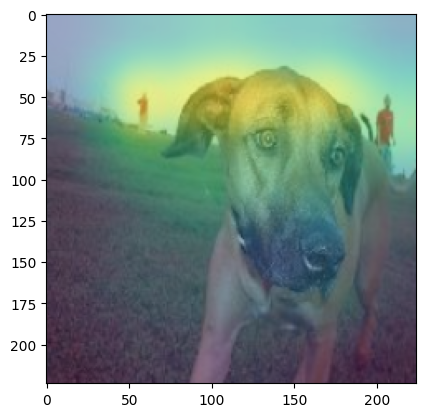

In [77]:
from captum.attr import LayerGradCam
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Resize, InterpolationMode
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import torch

# model
inputs = torchvision.io.read_image("./data/imagenet/images/ILSVRC2012_val_00000102.jpg").unsqueeze(0)
transform = torchvision.models.get_model_weights("resnet18").DEFAULT.transforms()
inputs = transform(inputs)
target = resnet(inputs).argmax(1).item()

# gradcam
explainer = LayerGradCam(resnet, layer=node.operator) # here
attrs = explainer.attribute(inputs, target=target, attribute_to_layer_input=True)

# # visualize
resize = Resize(size=inputs.shape[2:], interpolation=InterpolationMode.BICUBIC)

def denormalize3d(input, mean, std) -> torch.Tensor:
    assert (input.dim() in [3,4]), "Must provide 3D or 4D input"
    return (
        input
        * torch.Tensor(std)[:, None, None]
        + torch.Tensor(mean)[:, None, None]
    )

def get_heatmap_kwargs(
    attr: torch.Tensor,
    cmap: str = 'seismic',
    power: float = 1.0,
    interpolation = None,
):
    b = attr.abs().pow(power).mean().pow(1.0/power)*10
    cm_obj = getattr(cm, cmap)
    new_cm_data = cm_obj(range(cm_obj.N))[:,:3] * .85
    new_cm_obj = ListedColormap(new_cm_data)
    return dict(
        cmap = new_cm_obj,
        vmin = -b,
        vmax = b,
        interpolation = interpolation
    )

denormed = denormalize3d(inputs[0], mean=transform.mean, std=transform.std)
# resize(attrs.mean(0)).shape
plt.imshow(to_pil_image(denormed))
plt.imshow(resize(attrs.mean(1)).squeeze().detach().numpy(), alpha=.5)

### vit

In [80]:
# no cam target layer in vit
print(ma_vit.find_cam_target_node())

None


## Usage of ModelArchitecture for LRP

### resnet

In [83]:
ma_resnet.list_nodes()[:5]

[NodeInfo(opcode='placeholder', name='x', target='x'),
 NodeInfo(opcode='call_module', name='conv1', target='conv1'),
 NodeInfo(opcode='call_module', name='bn1', target='bn1'),
 NodeInfo(opcode='call_module', name='relu', target='relu'),
 NodeInfo(opcode='call_module', name='maxpool', target='maxpool')]

In [84]:
from torch import nn

def some_assign_rule_function(m):
    pass
    # if isinstance(m, nn.Conv2d):
    #     m.register_forward_hook()
    #     ...

for n in ma_resnet.list_nodes():
    some_assign_rule_function(n.operator)